# Projet numérique de Science des Données 2025

__Binôme numéro 33 -- KATAEVSKII Mikhail et GIRARDET Grégoire__

## Introduction

Dans ce projet, il s'agira d'étudier un jeu de données concernant des femmes diabétiques enceintes. Le diabète constitue un facteur de risque pour le bon déroulé de la grossesse. Pour chacune de ces femmes, nous disposons de 7 variables :
* `Age` : l'âge en années
* `Tension systolique` : la tension systolique en mmHg
* `Tension diastolique` : la tension diastolique en mmHg
* `Glycémie` : glycémie post-prandiale en mmol/L
* `Température` : température en °C
* `FC au repos` : fréquence cardiaque au repos
* `Risque` : degré de risque obstétrique (0 : faible, 1 : moyen, 2 : élevé)


Ce projet comporte trois partie :
1. Une analyse exploratoire des données
2. La construction d'un classifieur binaire permettant de séparer les femmes dont la grossesse est à risque de celles dont elle ne l'est pas
3. La construction d'un classifieur multi-classe permettant de séparer les grossesses en trois classes : hautement à risque, moyennement à risque, faiblement à risque.

## Instructions 
* Former un binôme et l'inscrire dans Moodle.
* Renseigner le numéro de binôme et vos noms tout en haut de ce notebook à l'emplacement indiqué.
* Déposer ce notebook complété **au plus tard le 10 juillet 2025, 23h59** sur Moodle.

La présence aux séances dédiés au mini-projet (20/06 et 7/07) est **notée**. 

Les questions **1 à 14** peuvent être traitées dès la première séance. 
La question **15** peut être traitée après la PC4.
Les questions **16 à 30** peuvent être traitées à partir de la PC5.

Pour des raisons pédagogiques (voir la note à ce sujet), **l'usage d'assistants de code ou d'agents conversationnels tels que ChatGPT, Copilot, Claude, LeChat est prohibé. Leur utilisation sera sanctionnée.**

### Question 1 (1pt)

Les données ont été récoltées dans une région défavorisée du monde, où les populations sont très pauvres et peuvent difficilement consulter. Quel peut être l'intérêt de déléguer à un algorithme la prédiction du risque obstétrique ? Quelles peuvent être les dérives (sociales, éthiques, économiques, psychologiques) d'une telle pratique ?

__Réponse__ : L'utilisation d'un algorithme permettrait à un plus grand nombre de personnes d'estimer les risques obstétriques, surtout dans les zones dépourvues de médecins, ou encore dans des zones difficilement accessibles.

Cependant, un tel algorithme peut ne pas être totalement fiable, et dans l'absence d'un médecin qualifié, les utilisateurs ne pourront pas vérifier les réponses données par cet algorithme. Les utilisateurs devront aussi effectuer les mesures nécessaires par eux-mêmes, ce qui diminue la précision de données fournies, et pourra conduire à des évaluations erronées.

Les dérives d'utilisation de cet algorithme sont nombreuses. Tout d'abord, une fausse estimation pourrait mettre en danger une personne à forte risque dans le cas où ce risque serait sous-évalué. Au contraire, une personne dont le risque serait sur-évalue pourrait décider à avorter et ne pas avoir d'enfants dans le futur, alors qu'elle ne présente pas de risque élevé.
L'utilisation massive d'un tel algorithme pourrait conduire à terme à une diminution du nombre de médecins qualifiés dans la région concernée (puisqu'il n'y aura *a priori* plus besoin de médecins pour effectuer cette tache) ce qui pourrait aggraver le problème.
De plus, cela pourrait conduire à la diminution du budget alloué au traitement de femmes diabétiques enceintes.
Sur le plan psychologique, la possibilité d'utiliser un algorithme découragerait les patients à consulter les médecins compétents, et pourrait même conduire à une perte de confiance vis à vis de la médecine lorsque les résultats données pas l'algorithme sont erronés. Ces personnes pourraient se tourner vers la médecine alternative, qui pourrait même nuire à leur santé.  

## Librairies usuelles

In [62]:
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme ()
from sklearn import preprocessing, decomposition, neighbors, metrics, model_selection, linear_model, neural_network, ensemble

plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

np.random.seed(19) 

## Chargement des données

Nous allons pour l'instant travailler avec le jeu de données d'entraînement `data/donnees_entrainement.csv` :

In [28]:
df_train = pd.read_csv('data/donnees_entrainement.csv')

Commençons par en extraire deux arrays, `X_train` et `y_train`, contenant d'une part les variables décrivant les observations et d'autre part leurs étiquettes :

In [29]:
X_train = np.array(df_train.drop('Risque', axis=1))
y_train = np.array(df_train['Risque'], dtype='int')

# 1. Exploration de données

## Distributions des variables

### Question 2 (1 pt)
Pour chaque variable, affichez un histogramme de sa distribution dans chacune des trois classes.

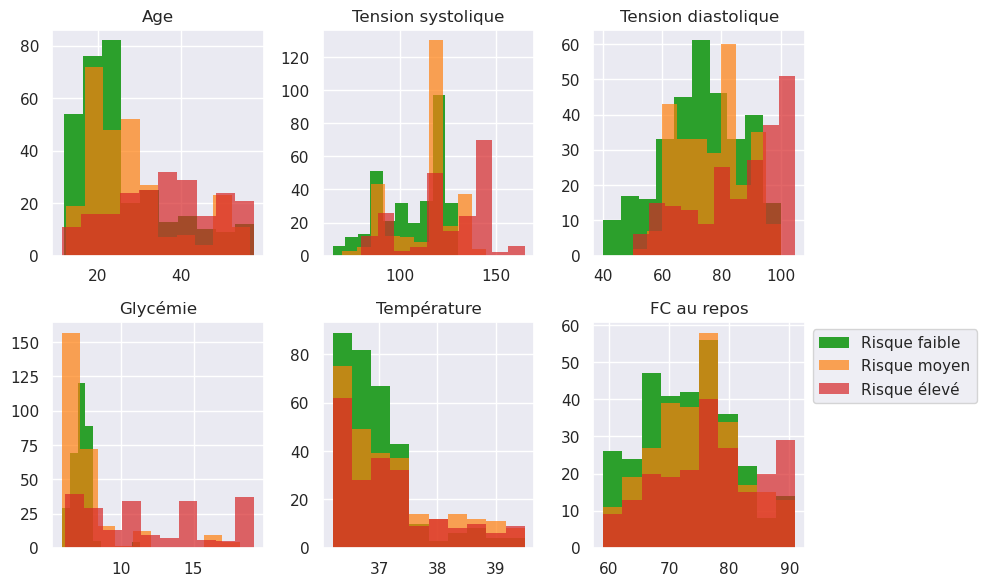

In [30]:
# Cette solution est adaptée de la PC 3

fig = plt.figure(figsize=(10, 6))

for (feat_idx, feat_name) in enumerate(df_train.columns[:-1]):
    ax = fig.add_subplot(2, 3, (feat_idx+1))

    h = ax.hist(df_train[df_train['Risque'] == 0][feat_name], bins=10,  
                color='tab:green', edgecolor='none', alpha=1, label='Risque faible')
    h = ax.hist(df_train[df_train['Risque'] == 1][feat_name], bins=10,  
                color='tab:orange', edgecolor='none', alpha=0.7, label='Risque moyen')
    h = ax.hist(df_train[df_train['Risque'] == 2][feat_name], bins=10,  
            color='tab:red', edgecolor='none', alpha=0.7, label='Risque élevé')
    
    ax.set_title(feat_name)

plt.legend(bbox_to_anchor=(1, 1))

fig.tight_layout(pad=1.0)

### Question 3 (1 pt)
Les valeurs prises par ces variables sont-elles surprenantes ? Cohérentes avec le degré de risque ?

__Réponse__ : Les données sont plutôt cohérentes. On s'attend par exemple à ce que le risque augmente avec l'âge, la tension systolique / diastolique et avec le taux de glycémie, ce qui correspond aux données observées. On le voit particulièrement bien avec le taux de glycémie, puisque la majorité de personnes avec un taux supérieur à 10 mmol/L ont un risque élevé.

Par contre, on pourrait aussi s'attendre à ce que le risque augmente avec la température ou la fréquence cardiaque, mais les données ne semblent pas confirmer cette hypothèse. La proportion de différentes catégories de risque reste à peu près uniforme pour les personnes qui présentent la température ou la fréquence cardiaque élevée. 

### Question 4 (1 pt)
Pensez-vous qu'il va être facile/difficile de prédire le risque de grossesse à risque en utilisant ces 6 variables ?

__Réponse__ : Il semble assez facile de prédire le risque à l'aide de ces six variables, voire même en ignorant quelques unes qui ne semblent pas déterminantes. On voit par exemple des pics bien distinctes pour la tension diastolique en fonction de catégorie de risque ou encore la fait que le taux de glycémie élevé est systématiquement associé à risque élevé.

Cependant, certaines variables ne permettent pas de distinguer les catégories de risque, par exemple la fréquence cardiaque (les 3 pics sont au même endroit). D'autres variables présentent une densité importante dans la même zone pour les trois catégorie (c'est le cas de la température, même si la température élevée augmente le risque, la plupart de valeurs sont inférieures à 37,5) ce qui rend la classification plus difficile.

## Réduction de dimension

Indépendamment de votre réponse à la question précédente, nous allons procéder à deux tentatives de réduction de dimension.

### Question 5 (1 pt)
Utilisez la décomposition en composantes principales de `X_train` pour visualiser les données en deux dimensions.

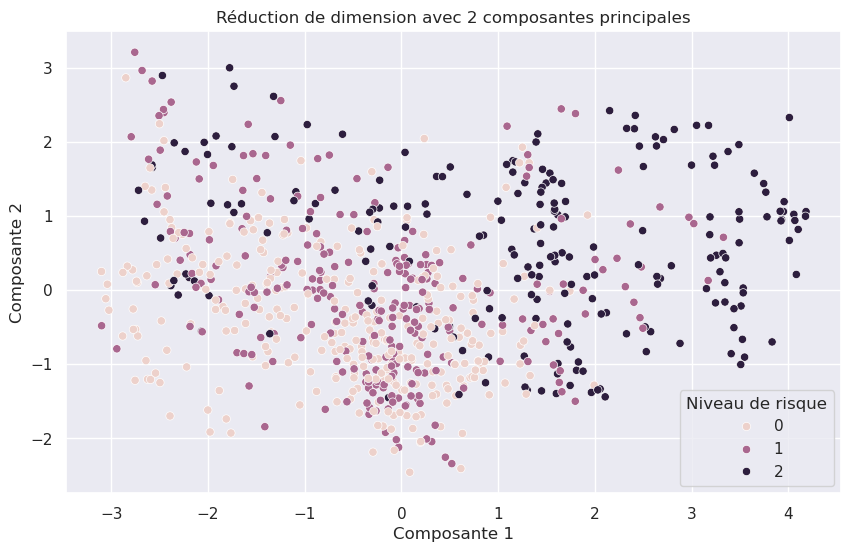

In [31]:
# Cette solution est adaptée de la PC 4

fig = plt.figure(figsize=(10, 6))

# Standardisation des données
std_scale = preprocessing.StandardScaler().fit (X_train)  # Standardisation des données
X_train_scaled = std_scale.transform (X_train)
# Projection sur deux composantes
pca = decomposition.PCA(n_components=2)
pca.fit (X_train_scaled)
X_train_projected = pca.transform (X_train_scaled)
# Affichage du résultat
sns.scatterplot (x=X_train_projected[:, 0], y=X_train_projected[:, 1], hue=y_train)
plt.xlabel ("Composante 1")
plt.ylabel ("Composante 2")
plt.title("Réduction de dimension avec 2 composantes principales")
plt.legend(title="Niveau de risque")


### Question 6 (1 pt) 
Pensez-vous utile d'utiliser cette ACP pour réduire la dimension des données pour construire un prédicteur de risque de grossesse difficile ?

__Réponse__ : On peut distinguer assez clairement les zones de risque élevé à partir de deux variables. Elles correspondent approximativement aux cas où la première composante est supérieure à 1 ou la deuxième composante est supérieure à 1. On peut aussi distinguer une zone de risque faible en bas à gauche. Par contre, on n'arrive pas à distinguer clairement les zones de risque faible et élevé.

Si notre but est de séparer les cas de risque élevé du reste on peux se contenter de cette ACP. Sinon, il faut utiliser plus de composantes.

### Question 7 (0,5 pt)
Affichez la matrice de corrélation entre les variables (étiquette exclue)

Text(0.5, 1.0, 'Corrélation entre les variables')

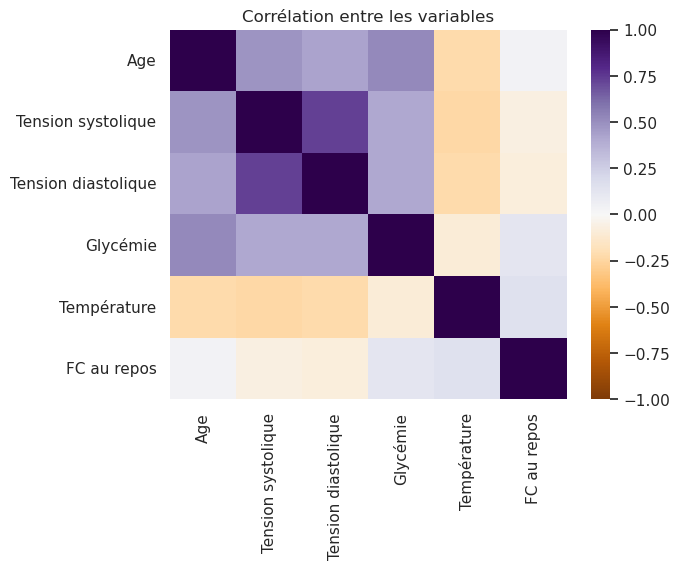

In [32]:
# Calcul de la matrice de corrélation deux à deux
corr_matrix = df_train.drop('Risque', axis=1).corr()

# Affichage heatmap
sns.heatmap(corr_matrix, 
            vmin=-1, # borne inf des valeurs à afficher
            vmax=1, # borne sup des valeurs à afficher
            center= 0, # valeur médiane des valeurs à afficher,
            cmap='PuOr', # colormap divergente de violet (PUrple) vers orange (ORange)
           )

# Titre
plt.title("Corrélation entre les variables")

### Question 8 (0,5 pt)

Comment utiliser cette matrice de corrélation pour réduire la dimension des données ?

__Réponse__ : On remarque que certaines variables sont forment corrélées, ce qui veut dire que l'on peut réduire la dimension sans risquer de perdre beaucoup d'information. On distingue à peu près 2 carrés indépendantes sur le graphe, donc on doit pouvoir se limiter à deux composantes principales. 

# 2. Classification «à risque» vs «sans risque»

Nous allons maintenant transformer les étiquettes en étiquettes binaire, en regroupant les risques obstétriques moyens et élevés. Les étiquettes `1` et `2` seront regroupées en une seule étiquette `1`.

In [33]:
# Copier le dataframe initial dans un nouveau dataframe 
df_train_risk_vs_norisk = df_train.copy()

# Regrouper les étiquettes 1 et 2
df_train_risk_vs_norisk['Risque'] = np.where(df_train['Risque']==2, 1, df_train['Risque'])

# Extraction de l'array d'étiquettes
y_train_risk_vs_norisk = np.array(df_train_risk_vs_norisk['Risque'], dtype='int')

df_train_risk_vs_norisk.head ()

,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
0,21.0,85.0,55.0,7.0,36.2,84.0,1
1,36.0,145.0,100.0,6.9,39.5,73.0,1
2,15.5,120.0,75.0,7.4,39.0,74.0,0
3,49.0,135.0,100.0,15.9,37.8,72.0,1
4,56.5,120.0,90.0,12.0,36.9,74.0,1


## Choix du critère d'évaluation
Pour cette section, on pourra se référer à la section 8.7.1 du poly.

### Question 9 (0,25 pt)
Quelle serait l'_accuracy_ (proportion d'observations correctement étiquetées) d'un modèle qui prédit que toutes les observations appartiennent à la classe majoritaire (c'est-à-dire la classe ayant le plus grand nombre d'observations dans les données) ? 

In [34]:
x = len(df_train_risk_vs_norisk[df_train_risk_vs_norisk['Risque'] == 1])
y = len(df_train_risk_vs_norisk)
print(f"L'accuracy est de {max(x, y - x) / y} si on étiquette tout comme faisant partie du groupe majoritaire.")

L'accuracy est de 0.605 si on étiquette tout comme faisant partie du groupe majoritaire.


### Question 10 (0,25 pt) 
La __précision équilibrée__ (_balanced accuracy_) d'un classifieur binaire est donnée par :

$$BA = \frac12 \left( \frac{\text{TP}}{\text{TP}+\text{FN}} +  \frac{\text{TN}}{\text{TN}+\text{FP}} \right)$$

Expliquez pourquoi ce critère d'évaluation est plus pertinent que l'accuracy pour sélectionner un classifieur optimal.

__Réponse__ : Cette grandeur est la moyenne du taux de vrais positifs et du taux de vrais négatifs. Pour la maximiser, il faut donc à la fois faire classifier correctement les positifs des négatifs. Contrairement à l'accuracy, cette grandeur est plus pertinente dans le cas où il y a très peu d'observation appartenant à une certaine classe.

Dans la suite du projet, nous utiliserons ce critère, implémenté dans la méthode [metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) de scikit-learn.

## Plus proche voisin
L'algorithme du plus proche voisin associe à une observation $\vec{x}$ l’étiquette du point du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 11 (0,5 pt)
En quoi consiste la phase d'entraînement d'un tel classifieur ?

__Réponse__ : La phase d’entraînement d'un tel modèle consiste simplement à mémoriser tous les points du jeu d’entraînement. C'est pendant la phase de prédiction qu'on va calculer le plus proche voisin et fournir la prédiction associée. 

### Question 12 (0,5 pt)
Quelle précision équilibrée attendez-vous _sur le jeu d'entraînement_ d'un algorithme du plus proche voisin ? Pourquoi ?

__Réponse__ : On a vu sur le graphe avec les 2 composantes principales que la majorité de points se situent dans la zone centrale du graphe, où les cas à faible risque sont mélangés avec les cas à risque moyen. On s'attend à ce que le taux d'erreur dans cette zone soit particulièrement élevé. En ce qui concerne les zones à droite et en haut, ce sont essentiellement des zones à risque élevé, mais on y trouve un nombre faible de points.

Il semble qu'il y a à peu près 1/3 des points dans les zones bien définies (donc avec une precision proche de 100%), et le reste dans des zones mixtes (on peut estimer la précision à 50%). On peut donc s'attendre à une précision finale proche de 66%.

### Question 13 (0,5 pt)
Vérifiez votre réponse sur les données, en utilisant la classe [neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [35]:
# On separe les données d'entrainement et de test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_train_scaled, y_train_risk_vs_norisk, test_size=0.20, random_state=27)

neigh = neighbors.KNeighborsClassifier()
neigh.fit(X_train, y_train)

print (f"BA = {metrics.balanced_accuracy_score(y_test, neigh.predict(X_test))}")

BA = 0.70625


La précision est plus faible que celle intuitée. Cela provient probablement du fait que la précision dans les zones à risque élevé est inférieure à 100%.

### Quesion 14 (0,5 pt)
Pour cet algorithme, vaut-il mieux utiliser les données d'origine ou les données centrées-réduites ? Justifiez votre réponse.

Il vaut mieux utiliser les données centrées-réduites afin de rapprocher les points qui possèdent des valeurs très grandes (ou très petites) les unes des autres.

## K plus proches voisins
L'algorithme des $K$ plus proche voisins associe à une observation $\vec{x}$ l’étiquette qui est majoritaires parmi celle des $K$ points du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 15 (1,5 pt)
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ (voir amphi 7 et PC5) pour déterminer une valeur optimale de $K$. 

* Justifiez votre choix de grille de valeurs.
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

In [36]:
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

Pour commencer, on peut tracer l'allure globale du graphe. Pour cela, on prendra 40 valeurs uniformément répartis sur toute la plage de valeurs possible ( donc allant de de 1 à $\frac{9}{10} \lvert y_{train} \rvert$ ). Contrairement à la PC5, on n'utilisera pas une échelle logarithmique puisque la plage de valeurs possibles est assez petite.

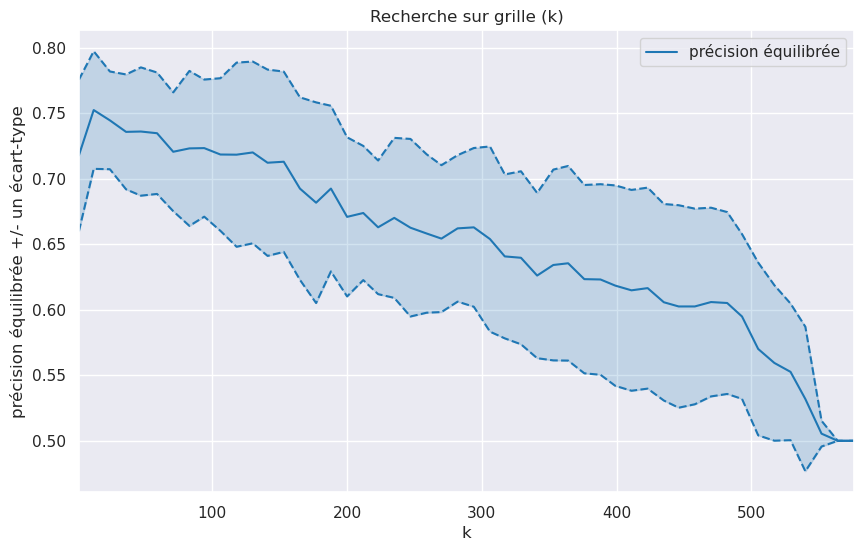

In [37]:
# Cette solution est adaptée de la PC 5

# Définir la grille de valeurs de l'hyperparamètre
ks = np.linspace(1, len(y_train) / 10 * 9, 50, dtype=int)


# Définir le modèle à évaluer
neigh = neighbors.KNeighborsClassifier()

# Instantier la recherche sur grille
grid = model_selection.GridSearchCV(neigh, {'n_neighbors': ks}, 
                                    cv=kf, # on utilise les folds déjà définis
                                    scoring='balanced_accuracy'
                                   )

# Utiliser la recherche sur grille
grid.fit(X_train_scaled, y_train_risk_vs_norisk)

plt.figure(figsize=(10, 6))

precision = grid.cv_results_['mean_test_score']
std_error = grid.cv_results_['std_test_score']

# afficher les RMSE :
plt.plot(grid.cv_results_['param_n_neighbors'], precision, 
             label="précision équilibrée", color='tab:blue')
plt.plot(grid.cv_results_['param_n_neighbors'], precision + std_error, 
             color='tab:blue', linestyle='dashed')
plt.plot(grid.cv_results_['param_n_neighbors'], precision - std_error, 
             color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(ks, (precision + std_error), (precision - std_error), 
                 color='tab:blue',
                 alpha=0.2, # contrôle la transparence
                )

# Mise en forme
plt.xlabel("k")
plt.ylabel("précision équilibrée +/- un écart-type")
plt.xlim([ks[0], ks[-1]])
plt.title("Recherche sur grille (k)")
plt.legend(loc='best')

On voit que la précision est maximale pour les faibles valeurs de k. Au contraire, pour les valeurs très grandes, cette précision est constante et vaut 1/2 (parce que dans ce cas là, on renvoie la valeur la plus fréquente dans tout le jeu de données). De manière générale, on voit que la précision diminue lorsque k augmente. Cela est probablement due au fait qu'en augmentant k on diminue le nombre de différentes zones de risque distinctes, tout en augmentant la tailles de celles qui restent (car on prend en compte un plus grand nombre de voisins) ce qui diminue précision.

On peut maintenant se concentrer la partie gauche de ca graphe.

Puisque le nombre de valeurs est assez faible, on peut calculer toutes les valeurs possibles de k 

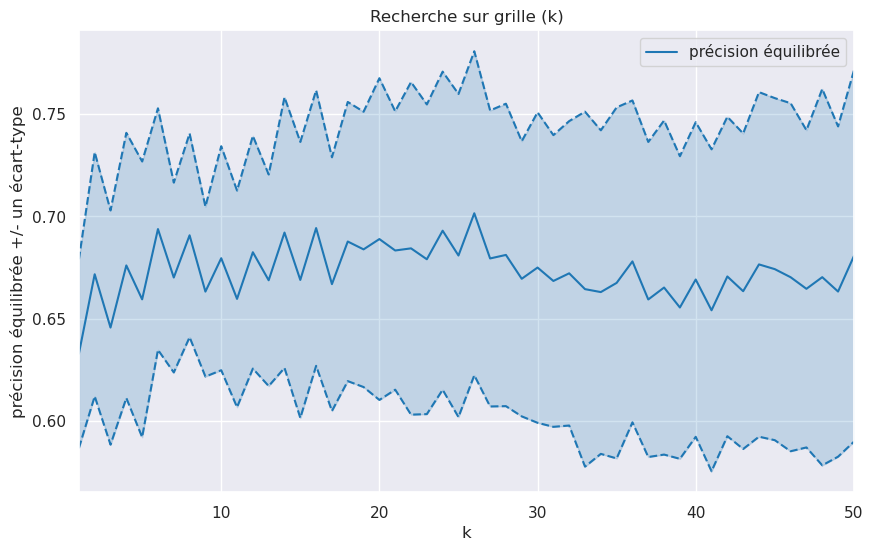

In [38]:
ks = np.arange(1, 51, 1)

# Instantier la recherche sur grille

grid = model_selection.GridSearchCV(neigh, {'n_neighbors': ks}, 
                                    cv=kf, # on utilise les folds déjà définis
                                    scoring='balanced_accuracy'
                                   )

# Utiliser la recherche sur grille
grid.fit(X_train_projected, y_train_risk_vs_norisk)

plt.figure(figsize=(10, 6))

precision = grid.cv_results_['mean_test_score']
std_error = grid.cv_results_['std_test_score']

# afficher les RMSE :
plt.plot(grid.cv_results_['param_n_neighbors'], precision, 
             label="précision équilibrée", color='tab:blue')
plt.plot(grid.cv_results_['param_n_neighbors'], precision + std_error, 
             color='tab:blue', linestyle='dashed')
plt.plot(grid.cv_results_['param_n_neighbors'], precision - std_error, 
             color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(ks, (precision + std_error), (precision - std_error), 
                 color='tab:blue',
                 alpha=0.2, # contrôle la transparence
                )

# Mise en forme
plt.xlabel("k")
plt.ylabel("précision équilibrée +/- un écart-type")
plt.xlim([ks[0], ks[-1]])
plt.title("Recherche sur grille (k)")
plt.legend(loc='best')

In [39]:
print(f"La meilleure valeur de k est {grid.best_params_['n_neighbors']} avec la précision équilibrée de {grid.best_score_}")

La meilleure valeur de k est 26 avec la précision équilibrée de 0.7015623502981995


## Régression logistique
Le pendant pour la classification binaire de la régression linéaire (amphi 7 et PC 5) est la __régression logistique__ (PC 6). Dans scikit-learn, elle est implémentée par la classe [linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### Question 16 (1 pt) 
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ pour déterminer une valeur optimale du coefficient de régularisation d'une régression logistique. 

* Justifiez votre choix de type de régularisation et de grille de valeurs. 
* Illustrez par un graphique approprié votre exploration de cette grille. 
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

Comme on l'a vu sur les graphes au début du sujet, plusieurs paramètres ne permettent pas de distinguer clairement les différents niveaux de risque. On préférera donc une régularisation de type "l1" afin d'annuler ces coefficients peu utiles.

On commence de nouveau avec avec un graphique assez grand pour identifier les plateaux. Une fois qu'on a identifié la zone qui nous intéresse, on trace uniquement cette zone là. Ici, on travaille de nouveau en logarithmique puisque la plage de valeurs qui présentent des variations est assez grande.

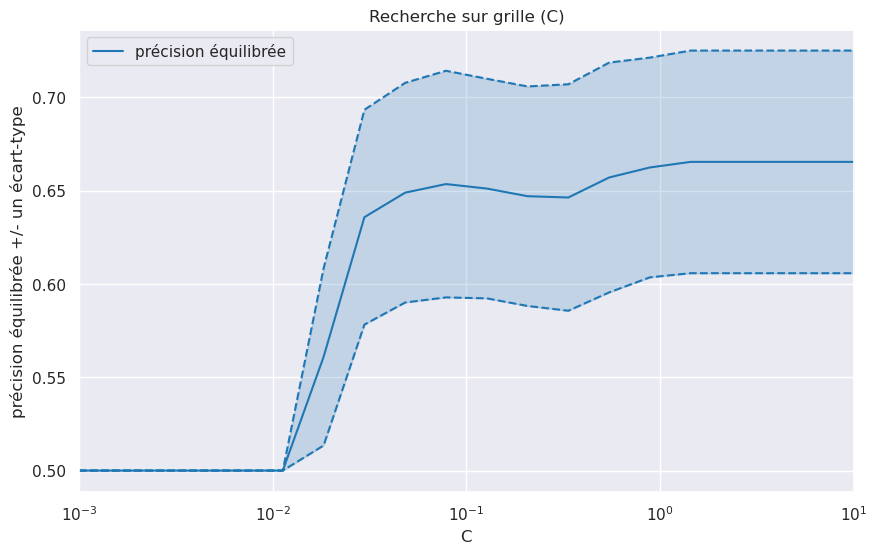

In [40]:
# Cette solution est adaptée de la PC 5

# Ce calcul peut prendre plus de 30 secondes à se terminer...

# Définir la grille de valeurs de l'hyperparamètre
cs = np.logspace(-3, 1, 20)


# Définir le modèle à évaluer
model = linear_model.LogisticRegression(penalty="l1", solver="saga", max_iter=10000)

# Instantier la recherche sur grille
grid = model_selection.GridSearchCV(model, {'C': cs}, 
                                    cv=kf, # on utilise les folds déjà définis
                                    scoring='balanced_accuracy'
                                   )

# Utiliser la recherche sur grille
grid.fit(X_train_scaled, y_train_risk_vs_norisk)

plt.figure(figsize=(10, 6))

precision = grid.cv_results_['mean_test_score']
std_error = grid.cv_results_['std_test_score']

# afficher les RMSE :
plt.semilogx(grid.cv_results_['param_C'], precision, 
             label="précision équilibrée", color='tab:blue')
plt.semilogx(grid.cv_results_['param_C'], precision + std_error, 
             color='tab:blue', linestyle='dashed')
plt.semilogx(grid.cv_results_['param_C'], precision - std_error, 
             color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(cs, (precision + std_error), (precision - std_error), 
                 color='tab:blue',
                 alpha=0.2, # contrôle la transparence
                )

# Mise en forme
plt.xlabel("C")
plt.ylabel("précision équilibrée +/- un écart-type")
plt.xlim([cs[0], cs[-1]])
plt.title("Recherche sur grille (C)")
plt.legend(loc='best')

On observe un plateau à gauche de ce graphique, ce qui correspond au phénomène de sous-apprentissage, car on optimise la fonction sans tenir compte de données.

Cependant, de manière assez étonnante, on trouve un autre plateau avec une précision égale à 1 à droite du tableau. Il semble donc que le phénomène de surapprentissage n'est pas présent ici. Cela est peut-être du au nombre faible de paramètres dans notre modèle.

In [41]:
print(f"La meilleure valeur de C est {grid.best_params_['C']} avec la précision équilibrée de {grid.best_score_}")

La meilleure valeur de C est 1.438449888287663 avec la précision équilibrée de 0.6654428031786523


## Algorithme non-linéaire

### Question 17 (2pt)
Choisissez maintenant un algorithme permettant d'apprendre un modèle non-linéaire parmi ceux du chapitre 9 :
* arbre de décision : [tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* forêt aléatoire : [ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* machine à vecteur de support à noyau : [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* perceptron multi-couche : [neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Utilisez encore une fois une recherche sur grille avec une validation croisée en 10 _folds_ pour sélectionner le(s) hyperparamètre(s) le(s) plus pertinent(s).

* Justifiez votre choix d'hyperparamètre(s) à optimiser.
* Justifiez votre choix de grille de valeurs pour ces ou cet hyperparèmtre(s).
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la ou les valeur(s) optimale(s) d'hyperparamètre(s) et la précision équilibrée correspondante.

On va utiliser le perceptron multi-couche

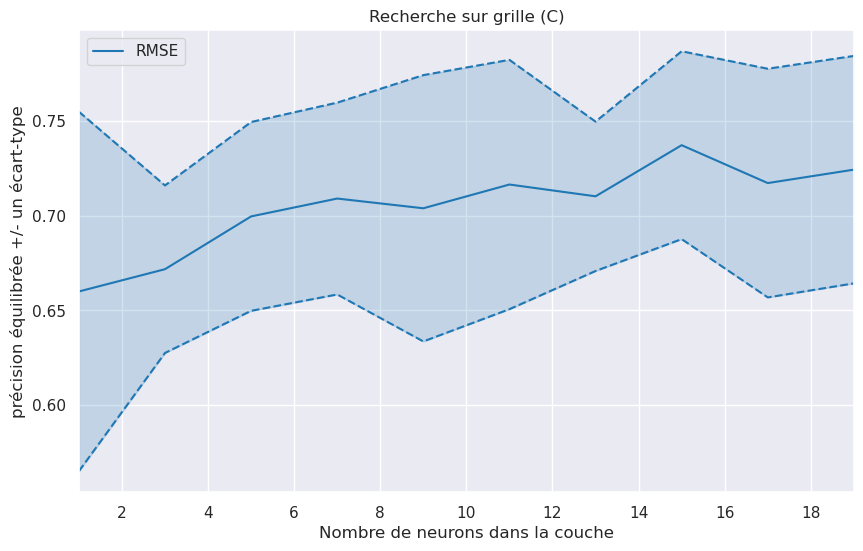

In [ ]:
# Cette solution est adaptée de la PC 5

# Ce calcul peut prendre plus de 30 secondes à se terminer...

# Définir la grille de valeurs de l'hyperparamètre C
layers = np.arange(1, 21, 2)


# Définir le modèle à évaluer
model = ensem(max_iter=10000)

# Instantier la recherche sur grille
grid = model_selection.GridSearchCV(model, {'hidden_layer_sizes': layers}, 
                                    cv=kf, # on utilise les folds déjà définis
                                    scoring='balanced_accuracy'
                                   )

# Utiliser la recherche sur grille
grid.fit(X_train_scaled, y_train_risk_vs_norisk)

plt.figure(figsize=(10, 6))

precision = grid.cv_results_['mean_test_score']
std_error = grid.cv_results_['std_test_score']

# afficher les RMSE :
plt.plot(grid.cv_results_['param_hidden_layer_sizes'], precision, 
             label="RMSE", color='tab:blue')
plt.plot(grid.cv_results_['param_hidden_layer_sizes'], precision + std_error, 
             color='tab:blue', linestyle='dashed')
plt.plot(grid.cv_results_['param_hidden_layer_sizes'], precision - std_error, 
             color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(layers, (precision + std_error), (precision - std_error), 
                 color='tab:blue',
                 alpha=0.2, # contrôle la transparence
                )

# Mise en forme
plt.xlabel("Nombre de neurons dans la couche")
plt.ylabel("précision équilibrée +/- un écart-type")
plt.xlim([layers[0], layers[-1]])
plt.title("Recherche sur grille (C)")
plt.legend(loc='best')

## Classification après réduction de dimension

Nous allons maintenant évaluer l'impact d'une réduction de dimension sur la qualité de l'apprentissage.

### Question 18 (0,25 pt)
Quel algorithme (k plus proches voisins ; régression logistique ; algorithme non-linéaire de la question 16) vous a permis d'obtenir la meilleure performance ? 

### Quesion 19 (0,25 pt)
Utilisez le travail des questions 4 à 7 pour créer une nouvelle matrice représentant les données dans moins de dimensions qu'originellement. 

### Question 20 (0,25 pt)
Utilisez encore une fois une recherche sur grille pour optimiser les performances de cet algorithme, mais entrainé sur cette nouvelle matrice. 

### Question 21 (0,25 pt)
La réduction de dimension a-t-elle été utile ? Commentez.

## Classifieur final

### Question 22 (0,25 pt)
Au vu des performances observées jusqu'à présent, quel est l'algorithme d'apprentissage, son ou ses valeurs d'hyperparamètres, la transformation des données qui permettent d'obtenir la meilleure performance ? 

Utilisez cet algorithme pour entraîner un modèle de classification final `final_binary_classifier` sur l'ensemble du jeu d'entraînement.

### Question 23 (0,25 pt)

Chargez les données du jeu de test `data/donnees_reservees.csv`. Combinez les étiquettes 1 et 2 en une seule classe. 

### Question 24 (0,25 pt)

Utilisez `final_binary_classifier` pour prédire les étiquettes des observations de ce jeu de données. (N'oubliez pas d'appliquer d'éventuelles transformation des données.) 

### Question 25 (0,5 pt)
Comparez la précision équilibrée sur le jeu de test à celle obtenue en validation croisée lors de la sélection de modèle. Commentez.

### Question 26 (0,25 pt)
Utilisez [metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) pour afficher la matrice de confusion de ces prédictions.

### Question 27 (0,5 pt)
Commentez cette matrice de précision.

Considéreriez vous possible d'utilise ce classifieur pour décider, sur la base de ces quelques mesures faciles à obtenir en autonomie, quelles femmes référer pour un suivi médical attentif de leur grossesse ?

# 3. Classification multi-classe

### Question 28 (0,5 pt)
Parmi les algorithmes d'apprentissage supervisé que vous avez utilisé dans la section 2, le(s)quel(s) se prête(nt) directement à entraîner un classifieur multiclasse ?

__Réponse__ : Parmi les algorithmes que l'on a utilisé, la forêt aléatoire, l'algorithme des k plus proches voisins, et le classificateur du plus proche voisin se prêtent à l'entrainement d'un modèle multiclasses.

### Question 29 (1,5 pt)
Choisissez un des algorithmes mentionnés à la question précédente et entraînez-le sur le problème de classification multi-classe consistant à prédire le niveau (0, 1 ou 2) de risque obstétrique. Optimisez le ou les hyperparamètre(s) le(s) plus pertinent(s).

__Réponse__ : On utilise l'algorithme de la forêt aléatoire, qui a donné les meilleurs résultats pour la classification binaire. Le seul hyperparamètre à optimiser est le nombre de plus proches voisins.

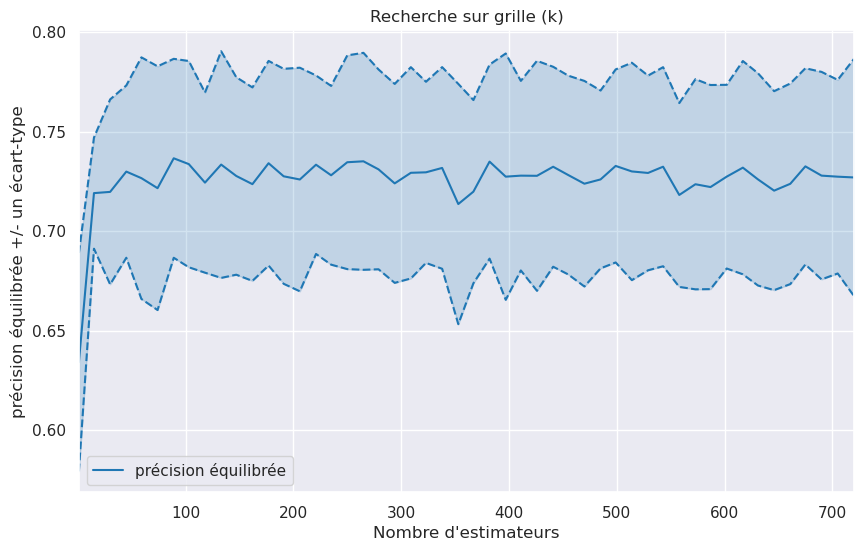

In [65]:
# Cette solution est adaptée de la PC 5

# Obtention des données
X_train = np.array(df_train.drop('Risque', axis=1))
y_train = np.array(df_train['Risque'], dtype='int')

# Standardisation des données
std_scale = preprocessing.StandardScaler().fit (X_train)  # Standardisation des données
X_train_scaled = std_scale.transform (X_train)

# Définir la grille de valeurs de l'hyperparamètre
ks = np.linspace(1, len(y_train) / 10 * 9, 50, dtype=int)
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

# Définir le modèle à évaluer
forest = ensemble.RandomForestClassifier()

# Instantier la recherche sur grille
grid = model_selection.GridSearchCV(forest, {'n_estimators': ks}, 
                                    cv=kf, # on utilise les folds déjà définis
                                    scoring='balanced_accuracy',
                                    n_jobs=-1
                                   )

# Utiliser la recherche sur grille
grid.fit(X_train_scaled, y_train)

plt.figure(figsize=(10, 6))

precision = grid.cv_results_['mean_test_score']
std_error = grid.cv_results_['std_test_score']

# afficher les RMSE :
plt.plot(grid.cv_results_['param_n_estimators'], precision, 
             label="précision équilibrée", color='tab:blue')
plt.plot(grid.cv_results_['param_n_estimators'], precision + std_error, 
             color='tab:blue', linestyle='dashed')
plt.plot(grid.cv_results_['param_n_estimators'], precision - std_error, 
             color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(ks, (precision + std_error), (precision - std_error), 
                 color='tab:blue',
                 alpha=0.2, # contrôle la transparence
                )

# Mise en forme
plt.xlabel("Nombre d'estimateurs")
plt.ylabel("précision équilibrée +/- un écart-type")
plt.xlim([ks[0], ks[-1]])
plt.title("Recherche sur grille (k)")
plt.legend(loc='best')

In [67]:
print(f"Le nombre d'estimateurs qui donne le meilleur résultat est {grid.best_params_['n_estimators']} avec la précision équilibrée de {grid.best_score_}")

Le nombre d'estimateurs qui donne le meilleur résultat est 89 avec la précision équilibrée de 0.7366045606237188


### Question 30 (1pt)
Utilisez cet algorithme pour entraîner un modèle multi-classe final sur l'ensemble des données d'entraînement. Évaluez ce modèle sur les données de test. Commentez.

BA sur le jeux de test: 0.7578733132597302


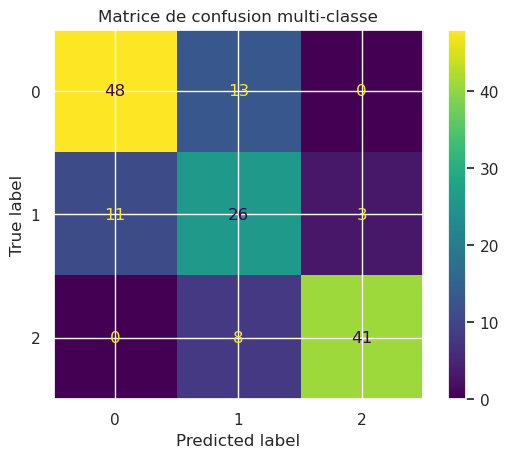

In [ ]:
# Génération des données de test
df_reserve = pd.read_csv('data/donnees_reservees.csv')
X_test = df_reserve.drop('Risque', axis=1).values
y_test = df_reserve['Risque'].astype(int).values

std_scale = preprocessing.StandardScaler().fit (X_test)  # Standardisation des données
X_test_scaled = std_scale.transform(X_test)

# Création de l'estimateur final et entrainement
final_multi = ensemble.RandomForestClassifier(
    n_estimators=grid.best_params_['n_estimators'],
    random_state=101
)
final_multi.fit (X_train_scaled, y_train)

# Prediction sur le jeux de test et précision
y_test_pred = final_multi.predict(X_test_scaled)
BA = metrics.balanced_accuracy_score(y_test, y_test_pred)
print(f"BA sur le jeux de test: {BA}")

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred,
    display_labels=["0", "1", "2"]
)
plt.title("Matrice de confusion multi-classe")
plt.show()

On remarque que le modèle est très bon pour classer correctement les patients, avec quelques erreurs, notamment de confusion entre patient à risque moyen et élevé. Il n'y a pas de confusion entre patients à haut risque et patients à risque faible, ce qui est très positif.